Device: cpu
Vocab size: 28, Train iters: 411, Val iters: 44
Epoch 01 | train 0.301 | val 0.054 | time 160.6s
Epoch 02 | train 0.071 | val 0.051 | time 149.7s
Epoch 03 | train 0.062 | val 0.048 | time 149.4s
Epoch 04 | train 0.058 | val 0.048 | time 151.6s
Epoch 05 | train 0.056 | val 0.047 | time 150.0s
Epoch 06 | train 0.055 | val 0.046 | time 147.4s
Epoch 07 | train 0.054 | val 0.047 | time 151.2s
Epoch 08 | train 0.053 | val 0.046 | time 149.9s
Entrenamiento finalizado. Mejor val loss: 0.0460890346122059

==> Visualizando codificación posicional (algunos canales)


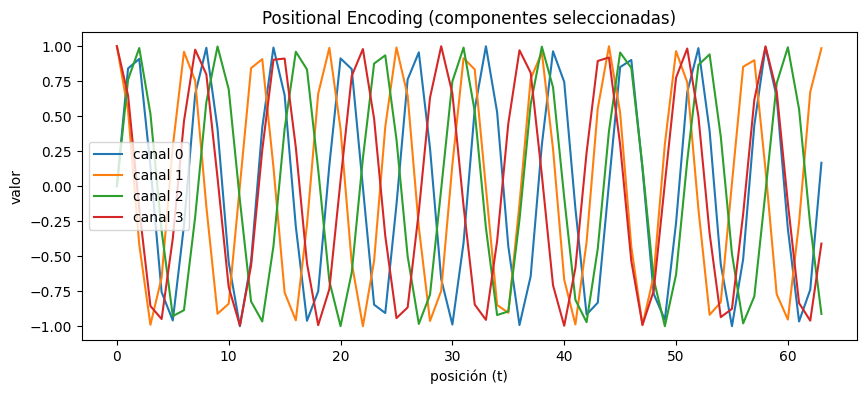

==> Visualizando una máscara causal (triangular superior -inf -> no visible)


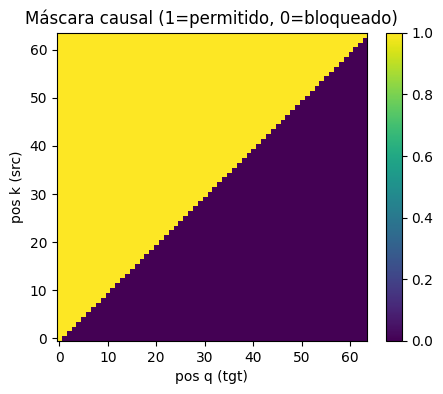

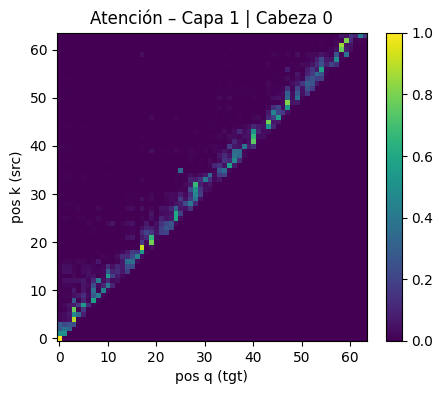

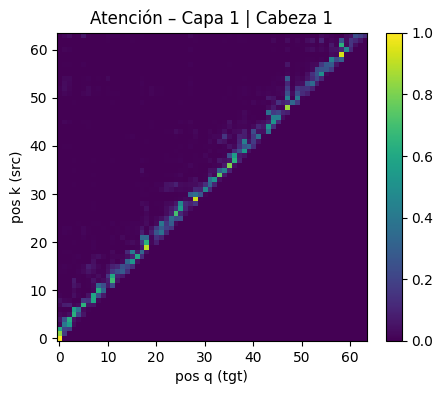

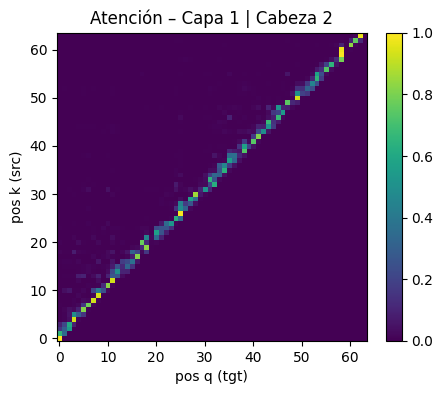

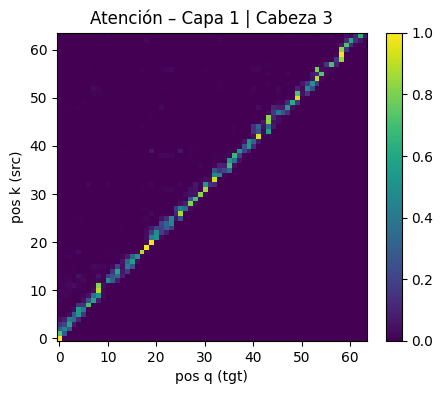

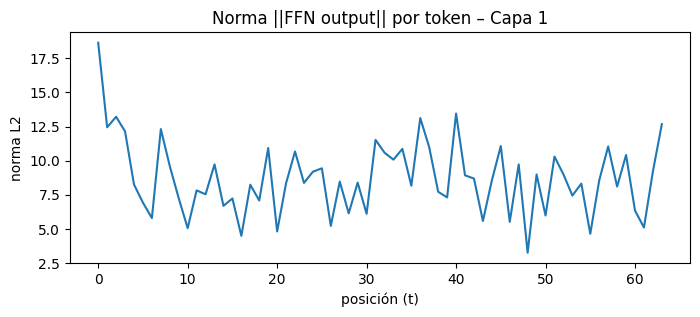

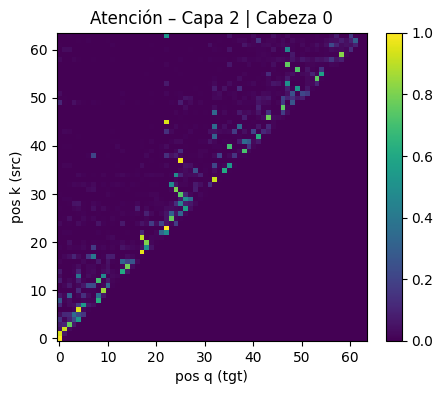

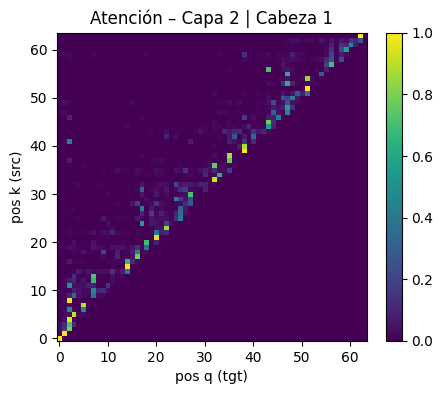

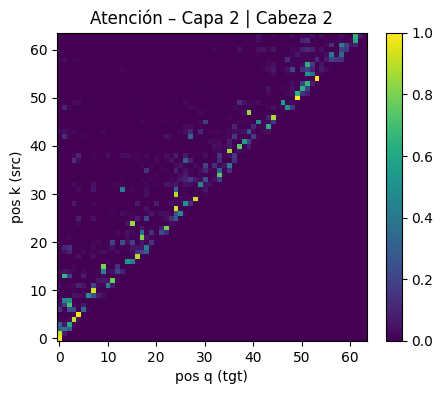

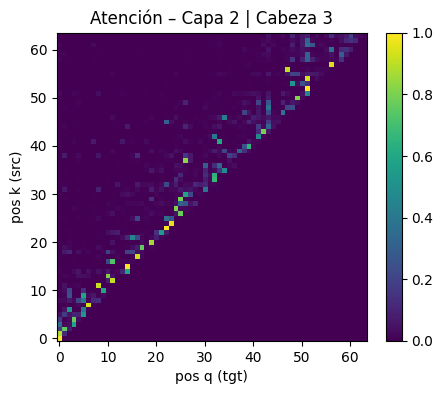

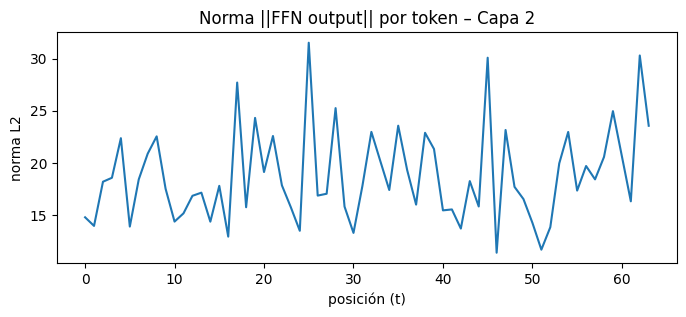

==> Visualizando representación final (norma por token)


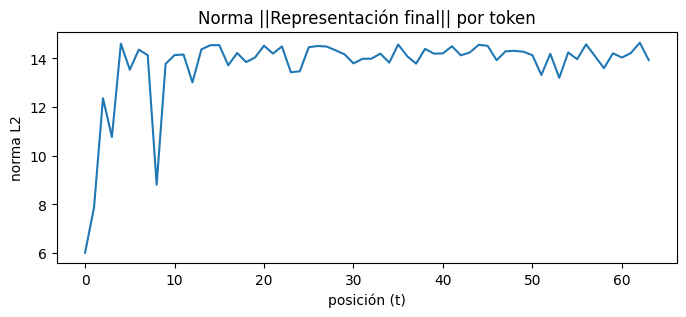


=== SAMPLE ===
attention is all you need. transformers enable parallel sequence modeling


=== SHAPES CLAVE ===
Token Embeddings: (64, 128) => [T, d_model]
Pos+Tok Embeddings: (64, 128) => [T, d_model]
Capa 1 - attn_out: (1, 64, 128) => [B,T,d_model]
Capa 1 - attn_weights: (1, 4, 64, 64) => [B,n_heads,T,T]
Capa 1 - ff_out: (1, 64, 128) => [B,T,d_model]
Capa 2 - attn_out: (1, 64, 128) => [B,T,d_model]
Capa 2 - attn_weights: (1, 4, 64, 64) => [B,n_heads,T,T]
Capa 2 - ff_out: (1, 64, 128) => [B,T,d_model]

Listo: entrenado, visualizado y muestreado. Ajusta CFG para jugar con cabezas/capas/contexto.


In [1]:
# ==============================================================
# Mini Transformer (Decoder-only) – Colab-ready
# - Tarea: modelado de lenguaje a nivel carácter (next-token)
# - Muestra partes internas: embeddings, posicionales, máscaras,
#   atenciones por cabeza/capa, salidas intermedias (hooks).
# - Entrenamiento rápido en corpus pequeño (demo educativo).
# ==============================================================

# ----------------------------
# 0) Importaciones y utilidades
# ----------------------------
import math, time, random, os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# 1) Configuración (edita aquí)
# ----------------------------
CFG = {
    "block_size": 64,         # longitud de contexto (tokens que ve el modelo)
    "batch_size": 64,         # tamaño de batch
    "n_layers": 2,            # capas del Transformer
    "n_heads": 4,             # cabezas de atención por capa
    "d_model": 128,           # dimensión del embedding (modelo)
    "d_ff": 256,              # dimensión interna del feed-forward
    "dropout": 0.1,           # dropout
    "epochs": 8,              # pocas épocas para demo rápida
    "lr": 3e-3,               # learning rate
    "seed": 42,               # reproducibilidad
}

torch.manual_seed(CFG["seed"])
random.seed(CFG["seed"])
np.random.seed(CFG["seed"])

# ----------------------------
# 2) Datos (corpus pequeño de ejemplo)
#    - Carácter a carácter (tokenización simple)
# ----------------------------
corpus = """
attention is all you need. transformers enable parallel sequence modeling
by replacing recurrence with self-attention. this demo trains a tiny
decoder-only transformer on character-level data to visualize heads and layers.
we keep the dataset intentionally small so training is fast in colab.
"""

# Ampliamos artificialmente el corpus repitiéndolo (sin violar derechos)
corpus = (corpus.strip() + "\n") * 100

chars = sorted(list(set(corpus)))
vocab_size = len(chars)
stoi = {ch:i for i,ch in enumerate(chars)}
itoi = {i:ch for ch,i in stoi.items()}

def encode(s): return torch.tensor([stoi[c] for c in s], dtype=torch.long)
def decode(t): return "".join([itoi[int(i)] for i in t])

data = encode(corpus)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ----------------------------
# 3) Dataset y DataLoader
# ----------------------------
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # Entrada: contexto de longitud block_size
        # Target: los siguientes tokens (desplazados 1)
        x = self.data[idx:idx + self.block_size]
        y = self.data[idx+1:idx + 1 + self.block_size]
        return x, y

train_ds = CharDataset(train_data, CFG["block_size"])
val_ds   = CharDataset(val_data, CFG["block_size"])
train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, drop_last=True)

print(f"Vocab size: {vocab_size}, Train iters: {len(train_dl)}, Val iters: {len(val_dl)}")

# ----------------------------
# 4) Positional Encoding (sinusoidal, clásico)
# ----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        # senos en índices pares, cosenos en impares
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

# ----------------------------
# 5) Bloque de Decoder con MultiheadAttention
#    - Extraemos pesos de atención (por cabeza) para visualización
# ----------------------------
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Buffers para inspección
        self.last_attn_weights = None   # [B, n_heads, T, T] (si average_attn_weights=False)
        self.last_attn_output  = None   # [B, T, d_model]
        self.last_ff_output    = None   # [B, T, d_model]

    def forward(self, x, attn_mask=None):
        # x: [B, T, d_model]
        # 1) Self-Attention con máscara causal
        residual = x
        attn_out, attn_w = self.self_attn(
            x, x, x,
            attn_mask=attn_mask,
            need_weights=True,
            average_attn_weights=False # importante: retorna por-cabeza
        )  # attn_out: [B,T,d_model], attn_w: [B, n_heads, T, T]
        x = self.ln1(residual + self.dropout(attn_out))

        # Guardar para visualización
        self.last_attn_weights = attn_w.detach()
        self.last_attn_output  = attn_out.detach()

        # 2) Feed-Forward + Residual
        residual = x
        ff_out = self.ff(x)        # [B,T,d_model]
        x = self.ln2(residual + ff_out)

        self.last_ff_output = ff_out.detach()
        return x

# ----------------------------
# 6) Modelo completo (Decoder-only LM)
# ----------------------------
class MiniTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, dropout, block_size):
        super().__init__()
        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, d_model)  # Embedding de tokens
        self.pos_enc = PositionalEncoding(d_model, max_len=block_size+10)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        # Buffers para inspección global
        self.last_token_emb = None    # [B,T,d_model]
        self.last_pos_added = None    # [B,T,d_model]
        self.last_layer_out = None    # [B,T,d_model]

    def generate_causal_mask(self, T):
        # Máscara causal: no mirar al futuro (triángulo superior -inf)
        # shape esperada por MultiheadAttention (batch_first=True): [T, T] o [B*n_heads, T, T]
        mask = torch.full((T, T), float('-inf'), device=device)
        mask = torch.triu(mask, diagonal=1)
        return mask

    def forward(self, idx):
        # idx: [B,T] tokens
        B, T = idx.size()
        assert T <= self.block_size, "T > block_size"
        # Embedding + Positional
        tok = self.tok_emb(idx)         # [B,T,d_model]
        self.last_token_emb = tok.detach()
        x = self.pos_enc(tok)           # [B,T,d_model]
        self.last_pos_added = x.detach()
        x = self.dropout(x)

        attn_mask = self.generate_causal_mask(T)  # [T,T]

        # Pilas de bloques decoder
        for layer in self.layers:
            x = layer(x, attn_mask)

        x = self.ln_f(x)
        self.last_layer_out = x.detach()
        logits = self.head(x)           # [B,T,vocab_size]
        return logits

    @torch.no_grad()
    def sample(self, prompt, max_new_tokens=100):
        self.eval()
        idx = encode(prompt).unsqueeze(0).to(device)  # [1, T0]
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits = self.forward(idx_cond)
            next_logits = logits[:, -1, :] / 1.0
            probs = F.softmax(next_logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # muestreo
            idx = torch.cat([idx, next_id], dim=1)
            if int(next_id) == stoi.get("\n", -999):
                break
        return decode(idx[0].cpu().numpy())

# ----------------------------
# 7) Entrenamiento
# ----------------------------
model = MiniTransformerLM(
    vocab_size=vocab_size,
    d_model=CFG["d_model"],
    n_layers=CFG["n_layers"],
    n_heads=CFG["n_heads"],
    d_ff=CFG["d_ff"],
    dropout=CFG["dropout"],
    block_size=CFG["block_size"]
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)  # [B,T,V]
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

best_val = float("inf")
for ep in range(1, CFG["epochs"]+1):
    t0 = time.time()
    tr = run_epoch(train_dl, train=True)
    va = run_epoch(val_dl, train=False)
    dt = time.time() - t0
    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), "best_mini_transformer.pth")
    print(f"Epoch {ep:02d} | train {tr:.3f} | val {va:.3f} | time {dt:.1f}s")

print("Entrenamiento finalizado. Mejor val loss:", best_val)

# ----------------------------
# 8) Inspección de partes y visualización
#    - Tomamos un batch del val_dl para "ver" adentro del modelo
# ----------------------------
model.eval()
xb, yb = next(iter(val_dl))
xb = xb.to(device)
with torch.no_grad():
    logits = model(xb)

# 8.1 Embeddings de tokens (primer elemento del batch)
emb_tok = model.last_token_emb[0].cpu().numpy()        # [T, d_model]
pos_added = model.last_pos_added[0].cpu().numpy()      # [T, d_model]
last_layer = model.last_layer_out[0].cpu().numpy()     # [T, d_model]
T = emb_tok.shape[0]

# 8.2 Visualización de componentes
def plot_positional_channels(pos_tensor, title):
    # Muestra 4 canales del embedding posicional para ver el patrón seno/cos
    plt.figure(figsize=(10,4))
    for c in [0,1,2,3]:
        plt.plot(pos_tensor[:, c], label=f"canal {c}")
    plt.title(title)
    plt.xlabel("posición (t)")
    plt.ylabel("valor")
    plt.legend()
    plt.show()

def plot_matrix(mat, title, xlabel="pos q (tgt)", ylabel="pos k (src)"):
    plt.figure(figsize=(5,4))
    plt.imshow(mat, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

print("\n==> Visualizando codificación posicional (algunos canales)")
plot_positional_channels(pos_added - emb_tok, "Positional Encoding (componentes seleccionadas)")

print("==> Visualizando una máscara causal (triangular superior -inf -> no visible)")
with torch.no_grad():
    mask = model.generate_causal_mask(T).detach().cpu().numpy()
# Mostramos 1 y 0 (permitido/bloqueado) para ilustrar (no -inf directamente)
mask_show = np.where(np.isneginf(mask), 0.0, 1.0)
plot_matrix(mask_show, "Máscara causal (1=permitido, 0=bloqueado)")

# 8.3 Atención por capa y cabeza (sobre el mismo batch)
for li, layer in enumerate(model.layers, start=1):
    attn_w = layer.last_attn_weights  # [B, n_heads, T, T]
    if attn_w is None:
        continue
    attn_w = attn_w[0].detach().cpu().numpy()  # [n_heads, T, T] del primer elemento del batch
    # Graficamos algunas cabezas (todas si son pocas)
    n_heads = attn_w.shape[0]
    heads_to_plot = list(range(min(n_heads, 4)))  # hasta 4 cabezas por capa
    for h in heads_to_plot:
        plot_matrix(attn_w[h], title=f"Atención – Capa {li} | Cabeza {h}")

    # Mostrar también la salida del feed-forward de la capa (norma por posición)
    ff = layer.last_ff_output[0].detach().cpu().numpy()  # [T, d_model]
    norms = np.linalg.norm(ff, axis=1)
    plt.figure(figsize=(8,3))
    plt.plot(norms)
    plt.title(f"Norma ||FFN output|| por token – Capa {li}")
    plt.xlabel("posición (t)")
    plt.ylabel("norma L2")
    plt.show()

print("==> Visualizando representación final (norma por token)")
final_norms = np.linalg.norm(last_layer, axis=1)
plt.figure(figsize=(8,3))
plt.plot(final_norms)
plt.title("Norma ||Representación final|| por token")
plt.xlabel("posición (t)")
plt.ylabel("norma L2")
plt.show()

# 8.4 Muestreo de texto para comprobar que aprendió algo de estructura
prompt = "attention is"
gen = model.sample(prompt, max_new_tokens=120)
print("\n=== SAMPLE ===")
print(gen)

# 8.5 Extra: inspección textual de shapes clave (primer paso del forward)
print("\n=== SHAPES CLAVE ===")
print("Token Embeddings:", emb_tok.shape, "=> [T, d_model]")
print("Pos+Tok Embeddings:", pos_added.shape, "=> [T, d_model]")
for i, layer in enumerate(model.layers, start=1):
    if layer.last_attn_output is not None:
        print(f"Capa {i} - attn_out:", tuple(layer.last_attn_output.shape), "=> [B,T,d_model]")
    if layer.last_attn_weights is not None:
        print(f"Capa {i} - attn_weights:", tuple(layer.last_attn_weights.shape), "=> [B,n_heads,T,T]")
    if layer.last_ff_output is not None:
        print(f"Capa {i} - ff_out:", tuple(layer.last_ff_output.shape), "=> [B,T,d_model]")

print("\nListo: entrenado, visualizado y muestreado. Ajusta CFG para jugar con cabezas/capas/contexto.")


Device: cpu
Epoch 01 | train 0.759/0.583 | val 0.418/0.811
Epoch 02 | train 0.506/0.785 | val 0.427/0.798
Epoch 03 | train 0.462/0.792 | val 0.392/0.830
Epoch 04 | train 0.397/0.830 | val 0.407/0.824
Epoch 05 | train 0.364/0.839 | val 0.379/0.832
Epoch 06 | train 0.361/0.839 | val 0.372/0.830


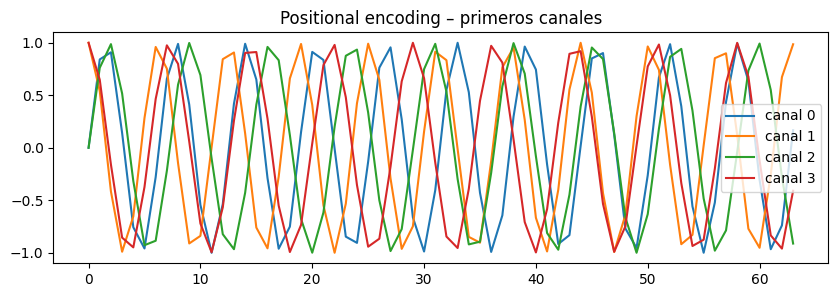

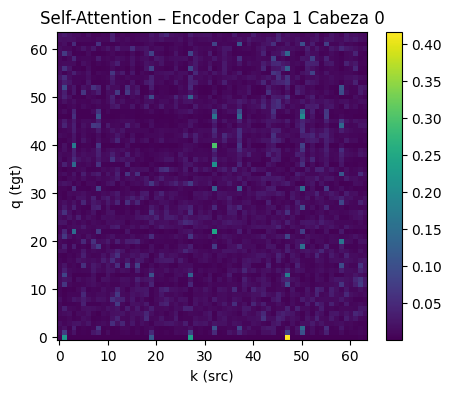

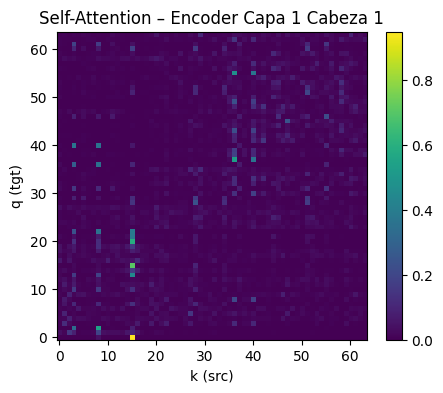

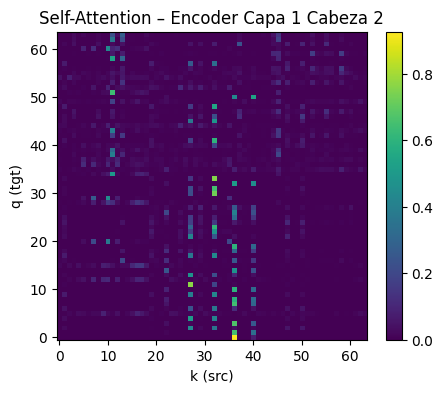

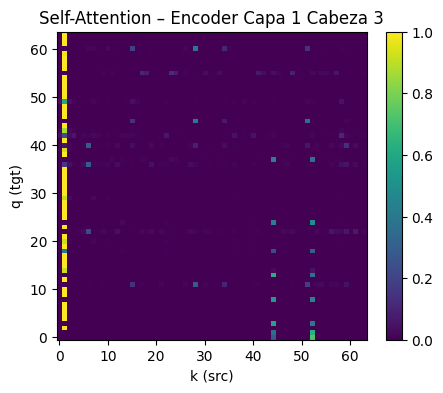

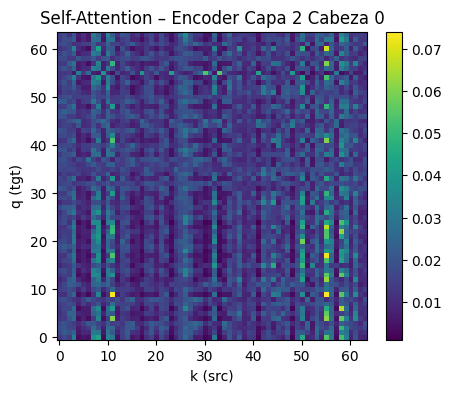

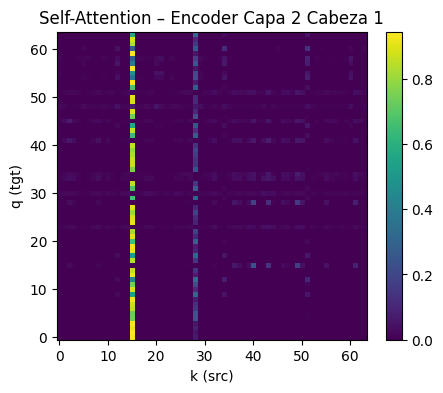

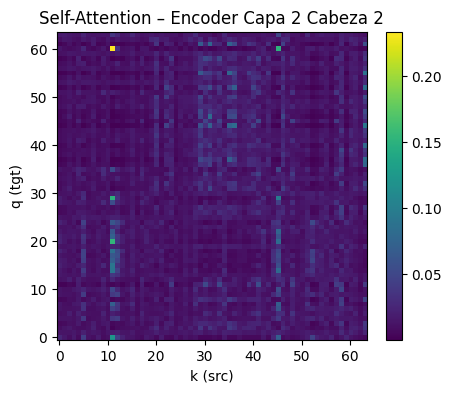

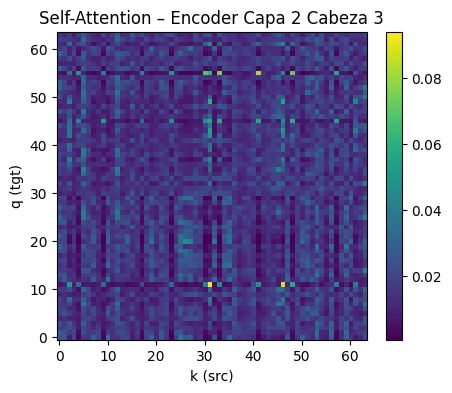

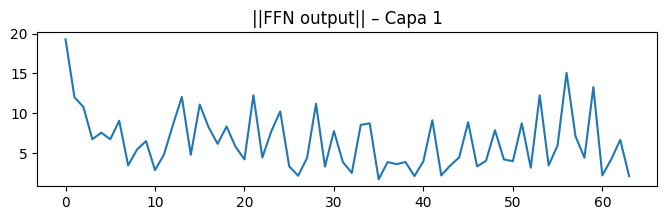

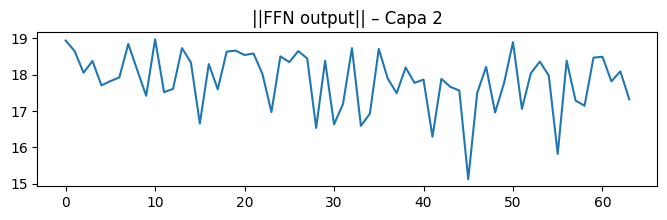

Listo: Encoder-only entrenado y visualizado.


In [2]:
# ==============================================================
# Mini Transformer Encoder-only (BERT-like) para clasificación
# - Tarea toy: clasificar si un texto contiene palabras "science" o "ai"
# - Muestra: embeddings, posicionales, self-attention por capa/cabeza
# - Rápido para Colab (dataset sintético)
# ==============================================================

import math, random, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# 1) Config (edita aquí)
# ----------------------------
CFG = dict(
    max_len=64,
    d_model=128,
    n_layers=2,
    n_heads=4,
    d_ff=256,
    dropout=0.1,
    batch_size=64,
    epochs=6,
    lr=3e-3,
    seed=42,
)
torch.manual_seed(CFG["seed"]); random.seed(CFG["seed"]); np.random.seed(CFG["seed"])

# ----------------------------
# 2) Dataset sintético
#    Etiqueta 1 si contiene "science" o "ai", 0 en caso contrario
# ----------------------------
pos_seeds = ["ai", "science", "intelligence", "model", "data", "learning"]
neg_seeds = ["football", "cooking", "travel", "beach", "guitar", "garden"]

def make_sentence(pos=True):
    k = random.randint(6, 14)
    bag = []
    for _ in range(k):
        if pos and random.random()<0.3:
            bag.append(random.choice(pos_seeds))
        elif (not pos) and random.random()<0.3:
            bag.append(random.choice(neg_seeds))
        else:
            # ruido
            w = "".join(random.choice("abcdefghijklmnopqrstuvwxyz") for _ in range(random.randint(3,8)))
            bag.append(w)
    random.shuffle(bag)
    return " ".join(bag)

def build_corpus(n=4000):
    xs, ys = [], []
    for _ in range(n//2):
        xs.append(make_sentence(True));  ys.append(1)
        xs.append(make_sentence(False)); ys.append(0)
    return xs, ys

train_texts, train_labels = build_corpus(3000)
val_texts,   val_labels   = build_corpus(1000)

# ----------------------------
# 3) Tokenización character-level con [CLS] y [PAD]
# ----------------------------
SPECIALS = ["[PAD]", "[CLS]", "[SEP]"]
chars = list("abcdefghijklmnopqrstuvwxyz ") + SPECIALS
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}
PAD, CLS, SEP = stoi["[PAD]"], stoi["[CLS]"], stoi["[SEP]"]

def encode_text(s, max_len):
    s = s.lower()
    ids = [CLS] + [stoi.get(c, stoi[" "]) for c in s][:max_len-2] + [SEP]
    ids = ids + [PAD]*(max_len-len(ids))
    return torch.tensor(ids, dtype=torch.long)

class TxtDS(Dataset):
    def __init__(self, texts, labels, max_len):
        self.x = [encode_text(t, max_len) for t in texts]
        self.y = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.x[i], self.y[i]

train_ds = TxtDS(train_texts, train_labels, CFG["max_len"])
val_ds   = TxtDS(val_texts,   val_labels,   CFG["max_len"])
train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, drop_last=False)

# ----------------------------
# 4) Positional Encoding (sinusoidal)
# ----------------------------
class PosEnc(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# ----------------------------
# 5) Bloque Encoder con MultiheadAttention
# ----------------------------
class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff  = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model), nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.last_attn = None
        self.last_ff   = None
    def forward(self, x, key_padding_mask=None):
        residual = x
        out, w = self.mha(x, x, x, key_padding_mask=key_padding_mask,
                          need_weights=True, average_attn_weights=False)
        x = self.ln1(residual + out)
        self.last_attn = w.detach()   # [B, n_heads, T, T]
        residual = x
        ff = self.ff(x)
        self.last_ff = ff.detach()
        x = self.ln2(residual + ff)
        return x

# ----------------------------
# 6) Modelo Encoder-only
# ----------------------------
class MiniBERT(nn.Module):
    def __init__(self, vocab, d_model, n_layers, n_heads, d_ff, dropout, max_len):
        super().__init__()
        self.tok = nn.Embedding(vocab, d_model, padding_idx=PAD)
        self.pos = PosEnc(d_model, max_len)
        self.layers = nn.ModuleList([EncoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, 2)
        self.last_tok = None
        self.last_pos = None
        self.last_enc = None
    def forward(self, ids):
        # ids: [B,T]
        mask_pad = (ids==PAD)  # [B,T] True donde hay pad
        x = self.tok(ids)      # [B,T,d]
        self.last_tok = x.detach()
        x = self.pos(x)        # suma posenc
        self.last_pos = x.detach()
        for lyr in self.layers:
            x = lyr(x, key_padding_mask=mask_pad)
        x = self.ln(x)         # [B,T,d]
        self.last_enc = x.detach()
        cls_vec = x[:,0,:]     # vector [CLS]
        logits = self.head(cls_vec)
        return logits

vocab_size = len(stoi)
model = MiniBERT(vocab_size, CFG["d_model"], CFG["n_layers"], CFG["n_heads"], CFG["d_ff"], CFG["dropout"], CFG["max_len"]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
crit = nn.CrossEntropyLoss()

def run_epoch(dl, train=True):
    model.train(train)
    tot=0; correct=0; n=0
    for xb,yb in dl:
        xb=xb.to(device); yb=yb.to(device)
        logits = model(xb)
        loss = crit(logits, yb)
        if train:
            opt.zero_grad(set_to_none=True); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
        tot += loss.item()*xb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred==yb).sum().item()
        n += xb.size(0)
    return tot/n, correct/n

best=0
for ep in range(1, CFG["epochs"]+1):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    va_loss, va_acc = run_epoch(val_dl, False)
    if va_acc>best: best=va_acc; torch.save(model.state_dict(),"mini_encoder_cls.pth")
    print(f"Epoch {ep:02d} | train {tr_loss:.3f}/{tr_acc:.3f} | val {va_loss:.3f}/{va_acc:.3f}")

# ----------------------------
# 7) Visualizaciones rápidas
# ----------------------------
model.eval()
xb, yb = next(iter(val_dl))
xb = xb.to(device)
with torch.no_grad(): _ = model(xb)

def show_matrix(M, title):
    plt.figure(figsize=(5,4)); plt.imshow(M, origin="lower", aspect="auto"); plt.colorbar(); plt.title(title); plt.xlabel("k (src)"); plt.ylabel("q (tgt)"); plt.show()

# Positional encoding (canales 0..3)
pos_only = (model.last_pos[0]-model.last_tok[0]).cpu().numpy()
plt.figure(figsize=(10,3))
for c in range(4):
    plt.plot(pos_only[:,c], label=f"canal {c}")
plt.legend(); plt.title("Positional encoding – primeros canales"); plt.show()

# Atención por capa/cabeza
T = xb.size(1)
for i, lyr in enumerate(model.layers, start=1):
    attn = lyr.last_attn[0].cpu().numpy()  # [n_heads,T,T] del primer ejemplo
    for h in range(min(attn.shape[0], 4)):
        show_matrix(attn[h], f"Self-Attention – Encoder Capa {i} Cabeza {h}")

# Magnitud FFN por token
for i, lyr in enumerate(model.layers, start=1):
    ff = lyr.last_ff[0].cpu().numpy()
    norms = np.linalg.norm(ff, axis=1)
    plt.figure(figsize=(8,2)); plt.plot(norms); plt.title(f"||FFN output|| – Capa {i}"); plt.show()

print("Listo: Encoder-only entrenado y visualizado.")


Device: cpu


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 01 | train 0.166 | val 0.001
Epoch 02 | train 0.001 | val 0.000
Epoch 03 | train 0.001 | val 0.000
Epoch 04 | train 0.000 | val 0.000
Epoch 05 | train 0.000 | val 0.000
Epoch 06 | train 0.000 | val 0.000
Epoch 07 | train 0.000 | val 0.000
Epoch 08 | train 0.000 | val 0.000


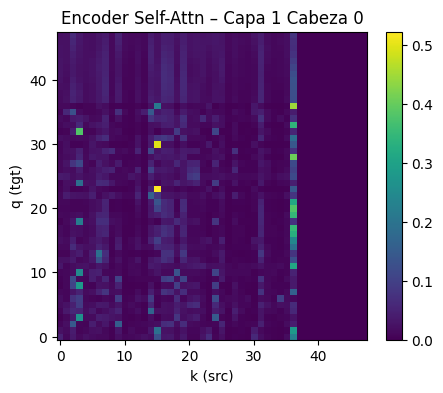

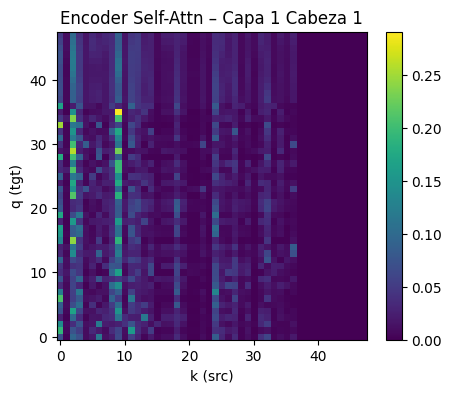

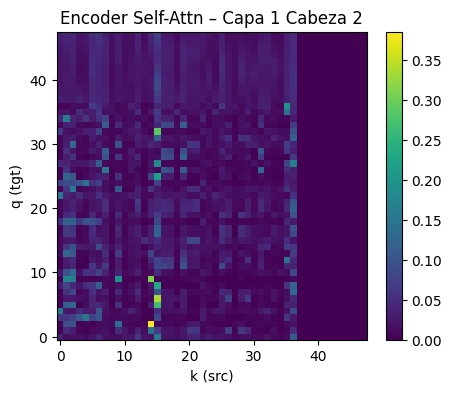

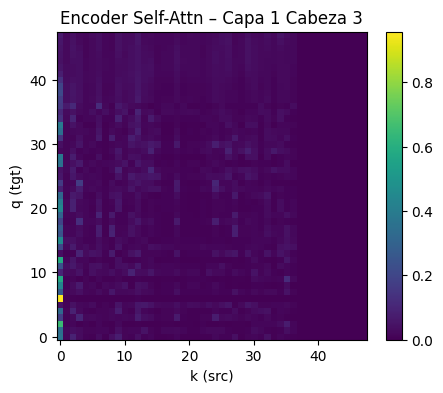

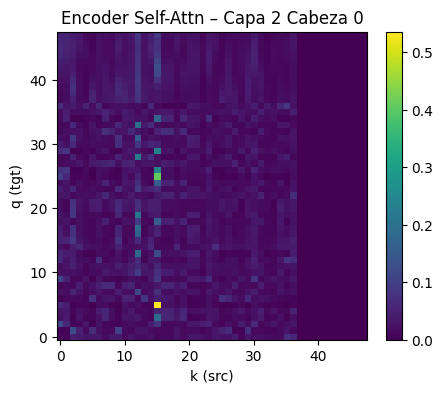

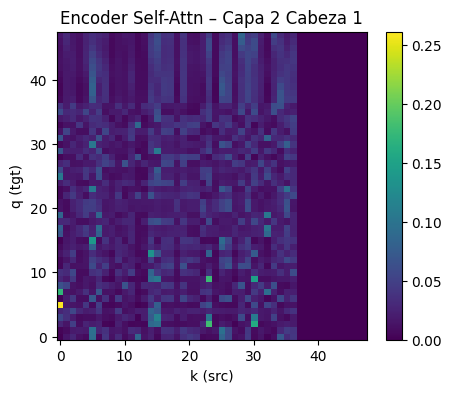

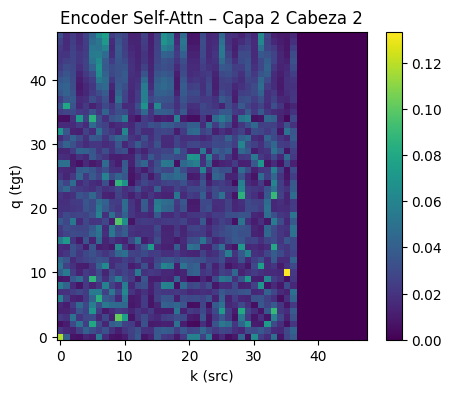

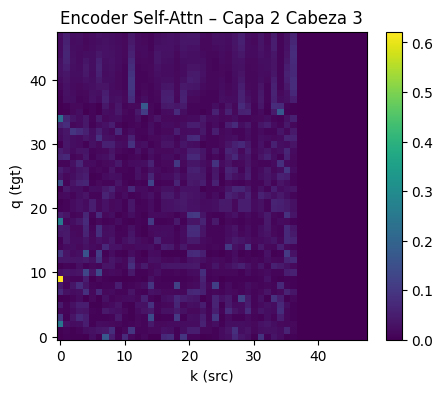

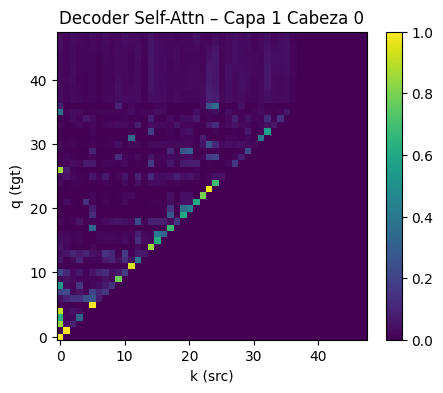

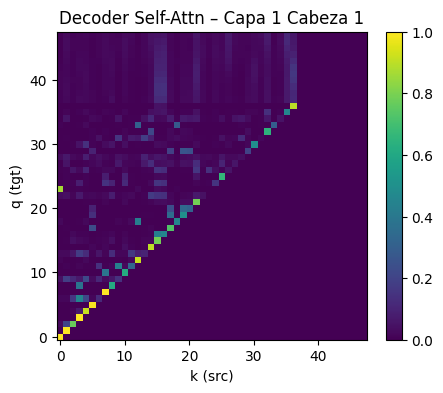

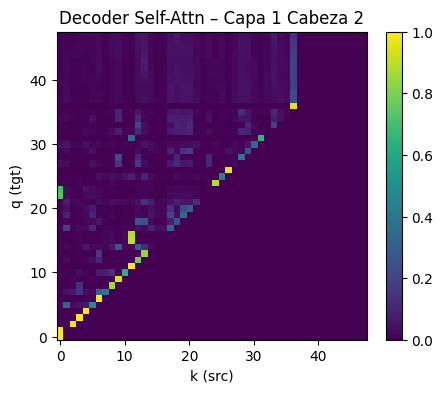

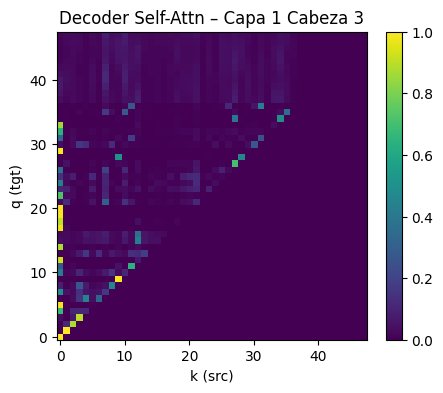

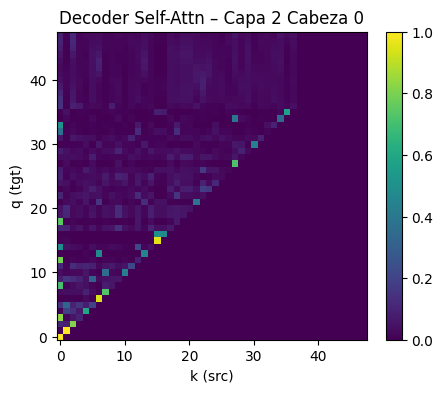

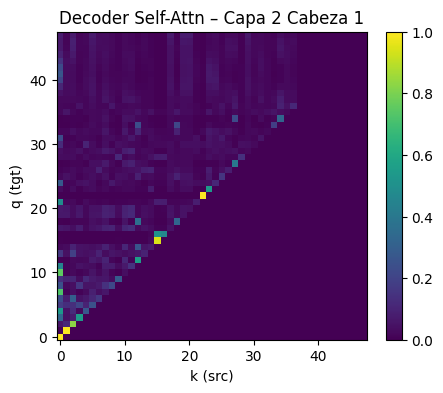

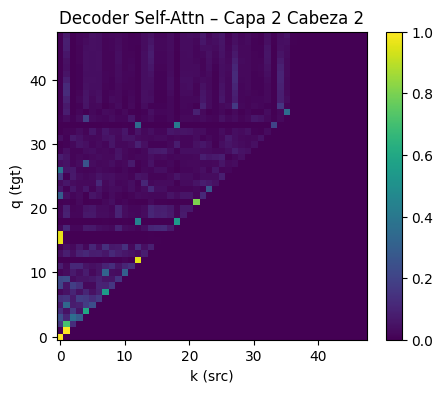

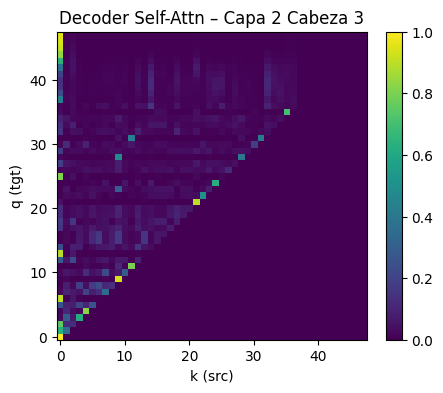

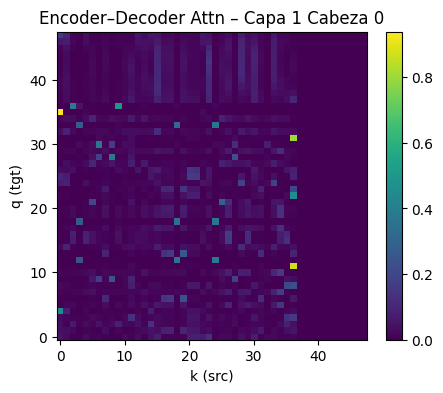

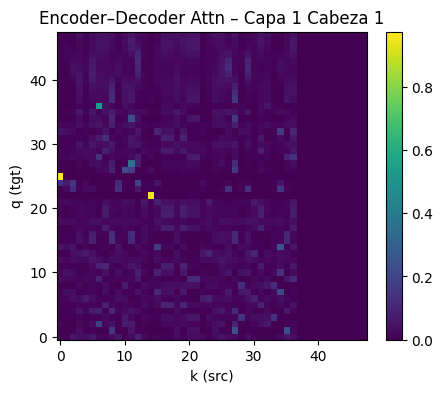

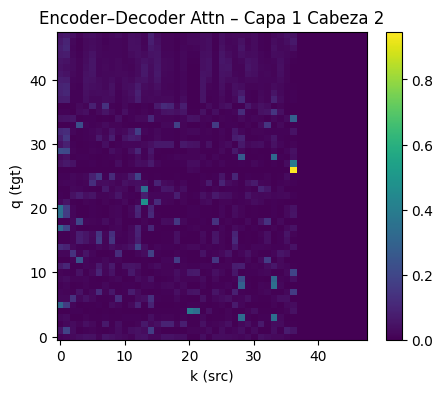

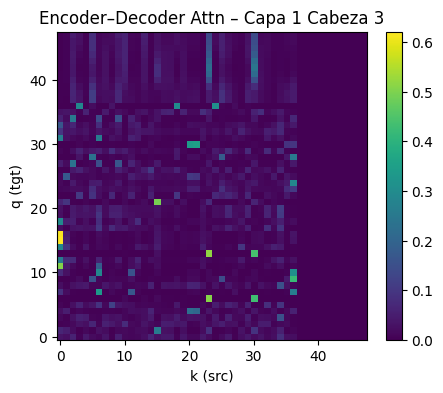

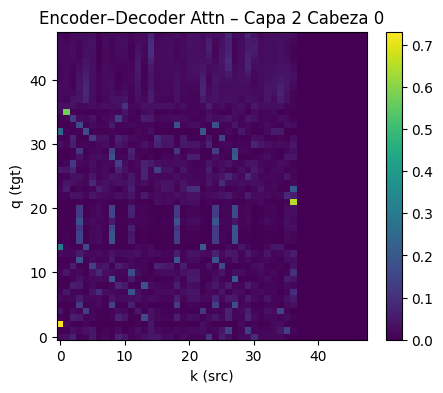

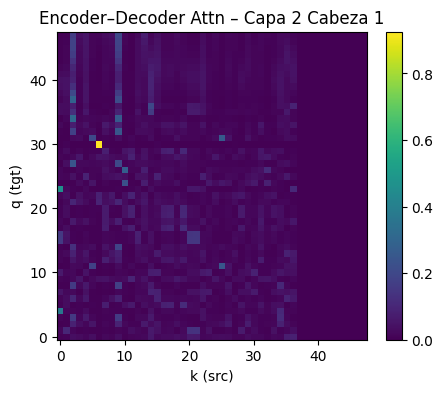

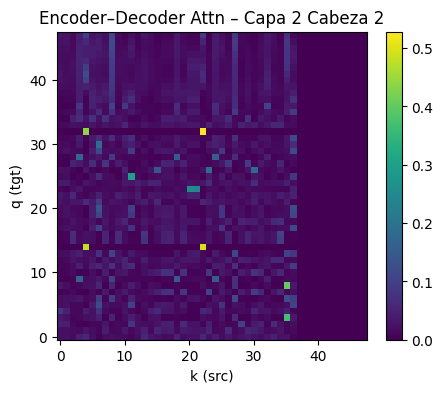

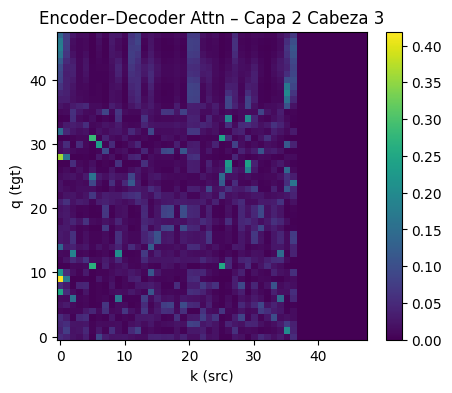

SRC: hello ai world.
OUT: 

SRC: transformers are fun
OUT: 

SRC: attention maps
OUT: 

SRC: reverse me, please!
OUT: 

Listo: Seq2Seq entrenado + 3 atenciones visualizadas.


In [4]:
# ==============================================================
# Mini Transformer Encoder–Decoder (seq2seq)
# - Tarea toy: "traducción" = invertir la secuencia de entrada (caracteres)
# - Muestra 3 atenciones: encoder self, decoder self (causal) y cross-attn
# - Entrenamiento con teacher forcing, rápido en Colab
# ==============================================================

import math, random, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------------------
# 1) Config
# ----------------------------
CFG = dict(
    max_len=48,
    d_model=128,
    n_layers=2,
    n_heads=4,
    d_ff=256,
    dropout=0.1,
    batch_size=64,
    epochs=8,
    lr=3e-3,
    seed=7,
)
torch.manual_seed(CFG["seed"]); random.seed(CFG["seed"]); np.random.seed(CFG["seed"])

# ----------------------------
# 2) Vocab (caracteres) + especiales
# ----------------------------
SPECIALS = ["<pad>","<bos>","<eos>"]
chars = list("abcdefghijklmnopqrstuvwxyz .,") + SPECIALS
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}
PAD, BOS, EOS = stoi["<pad>"], stoi["<bos>"], stoi["<eos>"]

def encode(s, max_len):
    s = s.lower()[:max_len-2]
    ids = [BOS] + [stoi.get(ch, stoi[" "]) for ch in s] + [EOS]
    ids = ids + [PAD]*(max_len-len(ids))
    return torch.tensor(ids, dtype=torch.long)

def decode(ids):
    out=[]
    for i in ids:
        ch = itos[int(i)]
        if ch in ["<pad>","<bos>"]: continue
        if ch=="<eos>": break
        out.append(ch)
    return "".join(out)

# ----------------------------
# 3) Dataset: entrada -> salida invertida
# ----------------------------
def make_sample():
    L = random.randint(10, 40)
    s = "".join(random.choice("abcdefghijklmnopqrstuvwxyz .,") for _ in range(L))
    t = s[::-1]
    return s, t

class RevDS(Dataset):
    def __init__(self, n, max_len):
        self.pairs = [make_sample() for _ in range(n)]
        self.max_len = max_len
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        src, tgt = self.pairs[i]
        src_ids = encode(src, self.max_len)
        tgt_ids = encode(tgt, self.max_len)
        # teacher forcing: inputs del decoder (shift-right)
        dec_in  = tgt_ids.clone()
        # y objetivo: igual que tgt_ids pero desplazado a la izquierda (predice el siguiente)
        y = tgt_ids.clone()
        dec_in[dec_in==EOS] = EOS
        return src_ids, dec_in, y

train_ds = RevDS(4000, CFG["max_len"])
val_ds   = RevDS(1000, CFG["max_len"])
train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False, drop_last=True)

# ----------------------------
# 4) Positional Encoding
# ----------------------------
class PosEnc(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        # Truncate input if it exceeds max_len
        T = x.size(1)
        if T > self.pe.size(1):
            x = x[:, :self.pe.size(1), :]
            T = self.pe.size(1)
        return x + self.pe[:, :T, :]

# ----------------------------
# 5) Bloques
# ----------------------------
class EncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff  = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model), nn.Dropout(dropout))
        self.ln2 = nn.LayerNorm(d_model)
        self.last_attn=None; self.last_ff=None
    def forward(self, x, key_padding_mask=None):
        res=x
        out,w = self.mha(x,x,x,key_padding_mask=key_padding_mask, need_weights=True, average_attn_weights=False)
        x = self.ln1(res+out); self.last_attn=w.detach()
        res=x; ff=self.ff(x); self.last_ff=ff.detach()
        x = self.ln2(res+ff)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.cross_mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model), nn.Dropout(dropout))
        self.ln3 = nn.LayerNorm(d_model)
        self.last_self=None; self.last_cross=None; self.last_ff=None
    def forward(self, x, mem, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        res=x
        out,w1 = self.self_mha(x,x,x, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask,
                               need_weights=True, average_attn_weights=False)
        x = self.ln1(res+out); self.last_self=w1.detach()
        res=x
        out,w2 = self.cross_mha(x, mem, mem, key_padding_mask=memory_key_padding_mask,
                                need_weights=True, average_attn_weights=False)
        x = self.ln2(res+out); self.last_cross=w2.detach()
        res=x; ff=self.ff(x); self.last_ff=ff.detach()
        x = self.ln3(res+ff)
        return x

# ----------------------------
# 6) Modelo Seq2Seq
# ----------------------------
class MiniSeq2Seq(nn.Module):
    def __init__(self, vocab, d_model, n_layers, n_heads, d_ff, dropout, max_len):
        super().__init__()
        self.max_len=max_len
        self.src_emb = nn.Embedding(vocab, d_model, padding_idx=PAD)
        self.tgt_emb = nn.Embedding(vocab, d_model, padding_idx=PAD)
        self.pos = PosEnc(d_model, max_len)
        self.enc_layers = nn.ModuleList([EncoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.dec_layers = nn.ModuleList([DecoderBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.ln_e = nn.LayerNorm(d_model)
        self.ln_d = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab, bias=False)
        self.last_src_tok=None; self.last_tgt_tok=None
    def causal_mask(self, T):
        m = torch.full((T,T), float('-inf'), device=device)
        return torch.triu(m, 1)
    def forward(self, src_ids, tgt_in):
        # src_ids: [B,Ts], tgt_in: [B,Tt]
        src_pad = (src_ids==PAD); tgt_pad=(tgt_in==PAD)
        src = self.pos(self.src_emb(src_ids)); self.last_src_tok=src.detach()
        tgt = self.pos(self.tgt_emb(tgt_in)); self.last_tgt_tok=tgt.detach()

        # Encoder
        mem = src
        for L in self.enc_layers:
            mem = L(mem, key_padding_mask=src_pad)
        mem = self.ln_e(mem)

        # Decoder
        mask_tgt = self.causal_mask(tgt_in.size(1))
        x = tgt
        for L in self.dec_layers:
            x = L(x, mem, tgt_mask=mask_tgt, tgt_key_padding_mask=tgt_pad, memory_key_padding_mask=src_pad)
        x = self.ln_d(x)
        logits = self.head(x)
        return logits

    @torch.no_grad()
    def translate(self, src_text, max_new=60):
        self.eval()
        src = encode(src_text, CFG["max_len"]).unsqueeze(0).to(device)
        # encode
        src_pad = (src==PAD)
        mem = self.pos(self.src_emb(src))
        for L in self.enc_layers: mem = L(mem, key_padding_mask=src_pad)
        mem = self.ln_e(mem)

        # decode autoregresivo
        out = torch.tensor([[BOS]], device=device)
        for _ in range(max_new):
            tgt = self.pos(self.tgt_emb(out))
            mask = self.causal_mask(tgt.size(1))
            x = tgt
            for L in self.dec_layers:
                x = L(x, mem, tgt_mask=mask, tgt_key_padding_mask=None, memory_key_padding_mask=src_pad)
            x = self.ln_d(x)
            logits = self.head(x)[:,-1,:]
            probs = F.softmax(logits, dim=-1)
            nxt = torch.multinomial(probs, 1)
            out = torch.cat([out, nxt], dim=1)
            if nxt.item()==EOS: break
        return decode(out[0].tolist())

model = MiniSeq2Seq(len(stoi), CFG["d_model"], CFG["n_layers"], CFG["n_heads"], CFG["d_ff"], CFG["dropout"], CFG["max_len"]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])
crit = nn.CrossEntropyLoss(ignore_index=PAD)

def run_epoch(dl, train=True):
    model.train(train)
    tot=0; n=0
    for src, dec_in, y in dl:
        src, dec_in, y = src.to(device), dec_in.to(device), y.to(device)
        logits = model(src, dec_in)  # [B,T,V]
        loss = crit(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        if train:
            opt.zero_grad(set_to_none=True); loss.backward(); nn.utils.clip_grad_norm_(model.parameters(),1.0); opt.step()
        tot += loss.item()*src.size(0); n += src.size(0)
    return tot/n

best=float("inf")
for ep in range(1, CFG["epochs"]+1):
    tr = run_epoch(train_dl, True)
    va = run_epoch(val_dl, False)
    if va<best: best=va; torch.save(model.state_dict(),"mini_seq2seq_rev.pth")
    print(f"Epoch {ep:02d} | train {tr:.3f} | val {va:.3f}")

# ----------------------------
# 7) Visualización de atenciones (primer batch val)
# ----------------------------
model.eval()
src, din, y = next(iter(val_dl))
src = src.to(device); din=din.to(device)
with torch.no_grad(): _ = model(src, din)

def show_matrix(M, title):
    plt.figure(figsize=(5,4)); plt.imshow(M, origin="lower", aspect="auto"); plt.colorbar(); plt.title(title); plt.xlabel("k (src)"); plt.ylabel("q (tgt)"); plt.show()

# Encoder self-attn
for i, L in enumerate(model.enc_layers, start=1):
    att = L.last_attn[0].cpu().numpy()  # [n_heads, Ts, Ts]
    for h in range(min(att.shape[0], 4)):
        show_matrix(att[h], f"Encoder Self-Attn – Capa {i} Cabeza {h}")

# Decoder self-attn
for i, L in enumerate(model.dec_layers, start=1):
    att = L.last_self[0].cpu().numpy()  # [n_heads, Tt, Tt]
    for h in range(min(att.shape[0], 4)):
        show_matrix(att[h], f"Decoder Self-Attn – Capa {i} Cabeza {h}")

# Cross (encoder-decoder) attn
for i, L in enumerate(model.dec_layers, start=1):
    att = L.last_cross[0].cpu().numpy()  # [n_heads, Tt, Ts]
    for h in range(min(att.shape[0], 4)):
        show_matrix(att[h], f"Encoder–Decoder Attn – Capa {i} Cabeza {h}")

# Prueba de inferencia
tests = [
    "hello ai world.",
    "transformers are fun",
    "attention maps",
    "reverse me, please!"
]
for s in tests:
    out = model.translate(s)
    print(f"SRC: {s}\nOUT: {out}\n")
print("Listo: Seq2Seq entrenado + 3 atenciones visualizadas.")